# I) Summary

**DISCLAIMER**: We will use a simplier version of the LeNet-5 than the one in the [paper](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). (For example, computation on average pooling layers described in the paper are slightly more complex than usual).

LeNet-5 has:

- 2 Convolutional layers.
- 3 Fully connected layers.
- 2 Average pooling layers.
- Tanh as activation function for hidden layer.
- Softmax as activation function for output layer.
- 60000 trainable parameters.
- Cross-entropy as cost function
- Gradient descent as optimizer. (We will use Adam because it leads to better result)

LeNet-5 is:

- trained on MNIST dataset (60000 training examples).
- trained over 20 epoch.

LeNet-5 is expected to:
- converge after 10-12 epoch.
- have an error rate of 0.95% on test set. (Using accuracy as mettric)

![legend](../img/legend.png)

![LeNet-5 model](../img/lenet5-model.png)

# II) Implementation

In [2]:
from IPython.display import clear_output
import shutil
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## a) Loading dataset / Preprocessing

Notice:

- Pytorch let us preprocess our data (reshaping, normalizing) while loading our data.
- the format used for the image is the following: (n, C, H, W).

In [3]:
def load_mnist():
    transform = transforms.Compose([transforms.Resize((32,32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5], std=[0.5])])
            
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
    
    # Clear downloading message.
    clear_output()
    
    # Split dataset into training set and validation set.
    train_dataset, val_dataset = random_split(train_dataset, (55000, 5000))
    
    print("Image Shape: {}".format(train_dataset[0][0].numpy().shape), end = '\n\n')
    print("Training Set:   {} samples".format(len(train_dataset)))
    print("Validation Set:   {} samples".format(len(val_dataset)))
    print("Test Set:       {} samples".format(len(test_dataset)))
    
    # Create iterator.
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)
    
    # Delete the data/ folder.
    shutil.rmtree('./data')
    
    return (train_loader, val_loader, test_loader)

In [4]:
train_loader, val_loader, test_loader = load_mnist()

Image Shape: (1, 32, 32)

Training Set:   55000 samples
Validation Set:   5000 samples
Test Set:       10000 samples


---  
 <b>transforms.Normalize(mean=[0.5], std=[0.5])</b> ->  Normalize images over 1 channel in the range [-1,1].
 
 $$image[channel] = \frac{image[channel] - mean[channel]}{std[channel]}$$
 - <b>PROOF:</b> 
     - if $image[channel] = 0$ (minimum value) then $\frac{0 - 0.5}{0.5} = -1$.
     - if $image[channel] = 1$ (maximum value) then $\frac{1 - 0.5}{0.5} = 1$.
 

Thus it normalize images in the range of [-1,1].


## b) Visualization

In [5]:
def plot_example(X, y, y_pred=None):
    """
        Plots 9 examples and their associate labels.
        
        Parameters:
        -X: Training examples.
        -y: true labels.
        -y_pred: predicted labels.
    """
    # Create figure with 3 x 3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
     
    X, y = X[:9, 0, ...], y[:9] 
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(X[i])

        # Show true and predicted classes.
        if y_pred is None:
            xlabel = "True: {0}".format(y[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(y[i], y_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots in a single Notebook cell.
    plt.show()

In [6]:
def plot_example_errors(X, y, y_pred):
    """
        Plots 9 example errors and their associate true/predicted labels.
        
        Parameters:
        -X: Training examples.
        -y: true labels.
        -y_pred: predicted labels.
    
    """
    incorrect = (y != y_pred)
 
    X = X[incorrect]
    y = y[incorrect]
    y_pred = y_pred[incorrect]
    
    # Plot the first 9 images.
    plot_example(X, y, y_pred)

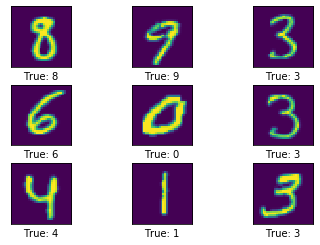

In [7]:
images, labels = iter(train_loader).next()
plot_example(images.numpy(), labels.numpy())

## c) Architecture build

In [8]:
class LeNet_5(nn.Module):
    
    def __init__(self):
        super(LeNet_5, self).__init__()
        
        self.C1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5))
        self.P1 = nn.AvgPool2d(kernel_size=(2,2), stride=2)
        self.C2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5))
        self.P2 = nn.AvgPool2d(kernel_size=(2,2), stride=2)

        self.FC1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.FC2 = nn.Linear(in_features=120, out_features=84)
        self.FC3 = nn.Linear(in_features=84, out_features=10)  
        
        
    def forward(self, x):
        x = torch.tanh(self.C1(x))
        x = self.P1(x)
        x = torch.tanh(self.C2(x))
        x = self.P2(x)
        x = x.view(-1, 16*5*5)
        x = torch.tanh(self.FC1(x))
        x = torch.tanh(self.FC2(x))
        # No need to use softmax because it is already called in
        # nn.CrossEntropyLoss().
        x = self.FC3(x)
    
        return x

In [9]:
model = LeNet_5()
model

LeNet_5(
  (C1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (P1): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (C2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (P2): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (FC1): Linear(in_features=400, out_features=120, bias=True)
  (FC2): Linear(in_features=120, out_features=84, bias=True)
  (FC3): Linear(in_features=84, out_features=10, bias=True)
)

In [10]:
loss_fct = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## d) Training the model

In [12]:
NB_EPOCHS = 20
NB_EXAMPLES = len(train_loader)
    
for epoch in range(NB_EPOCHS):  
    batch_cost = 0
    for inputs, labels in train_loader: 
        
        # zero the parameter gradients.
        optimizer.zero_grad()

        # forward + backward + optimize.
        predictions = model(inputs)
        loss = loss_fct(predictions, labels)
        loss.backward()
        optimizer.step()
        
        #batch_size = inputs.shape[0]
        #batch_cost += (loss.data.item() * batch_size)
        batch_cost += loss.data.item()
        
    batch_cost /= NB_EXAMPLES
    
    correct, total = 0, 0
    for inputs, labels in val_loader:
        predictions = model(inputs)
        # Compute accuracy.
        _, predicted = torch.max(predictions.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy =  correct / total
    
    print("[Epoch {}/{}]: Cost = {} | Validation accuracy = {}".format(epoch+1, NB_EPOCHS, batch_cost, accuracy))

[Epoch 1/20]: Cost = 0.37060712411306623 | Validation accuracy = 0.9582
[Epoch 2/20]: Cost = 0.1070125012680195 | Validation accuracy = 0.9738
[Epoch 3/20]: Cost = 0.06885745691698651 | Validation accuracy = 0.9788
[Epoch 4/20]: Cost = 0.051722464248061525 | Validation accuracy = 0.9822
[Epoch 5/20]: Cost = 0.040230404335442324 | Validation accuracy = 0.9828
[Epoch 6/20]: Cost = 0.03434317356955563 | Validation accuracy = 0.9846
[Epoch 7/20]: Cost = 0.026722759972759632 | Validation accuracy = 0.984
[Epoch 8/20]: Cost = 0.023744260961579722 | Validation accuracy = 0.9846
[Epoch 9/20]: Cost = 0.019367040098146642 | Validation accuracy = 0.9848
[Epoch 10/20]: Cost = 0.01697237064404045 | Validation accuracy = 0.986
[Epoch 11/20]: Cost = 0.012996578585426865 | Validation accuracy = 0.9846
[Epoch 12/20]: Cost = 0.011695819533819896 | Validation accuracy = 0.9844
[Epoch 13/20]: Cost = 0.011758659754914969 | Validation accuracy = 0.9868
[Epoch 14/20]: Cost = 0.009452458950663852 | Validation

In [13]:
# Save our model.
torch.save(model.state_dict(), 'lenet5_model')

## e) Evaluating the model

In [17]:
#Need to display the test accuracy.

In [14]:
model = LeNet_5()
# Load the model back.
model.load_state_dict(torch.load('lenet5_model'))

<All keys matched successfully>

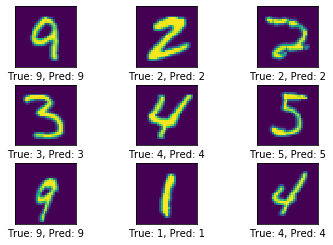

In [16]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
predictions = model(images)

_, predicted = torch.max(predictions, 1)

plot_example(images.numpy(), labels.numpy(), predicted.numpy())

# III) Conclusion

We can conclude that:

- The test set error (accuracy) is greater than 0.95% (0.9837%).
- It seems to start converging after 10-12 epochs.